In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from etna.datasets import TSDataset
from etna.transforms import LagTransform
from etna.models import CatBoostMultiSegmentModel
from etna.pipeline import Pipeline
from etna.models import LinearPerSegmentModel
from etna.metrics import SMAPE, MAPE

In [18]:
data = pd.read_csv('../data/processed/msk_segment_days.csv', index_col=0)
data.head()

,timestamp,target,segment
0,2018-03-04,4704280,k=3_t=11_r=1
1,2018-03-17,8000000,k=4_t=1_r=2
2,2018-04-03,11500000,k=6_t=1_r=3
3,2018-04-07,10200000,k=8_t=1_r=2
4,2018-04-18,11500000,k=16_t=1_r=1


In [19]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [20]:
data = data.groupby(['timestamp', 'segment']).agg({'target' : ['mean']}).reset_index()
data.columns = ["timestamp", "segment", "target"]

In [21]:
data

,timestamp,segment,target
0,2018-03-04,k=3_t=11_r=1,4.704280e+06
1,2018-03-17,k=4_t=1_r=2,8.000000e+06
2,2018-04-03,k=6_t=1_r=3,1.150000e+07
3,2018-04-07,k=8_t=1_r=2,1.020000e+07
4,2018-04-18,k=16_t=1_r=1,1.150000e+07
...,...,...,...
87961,2021-05-01,k=9_t=11_r=2,1.470608e+07
87962,2021-05-01,k=9_t=11_r=3,2.128014e+07
87963,2021-05-01,k=9_t=1_r=1,1.392500e+07
87964,2021-05-01,k=9_t=1_r=2,1.772667e+07


In [22]:
data_etna = TSDataset.to_dataset(data)
data_etna.head(5)

segment,k=0_t=11_r=1,k=0_t=11_r=2,k=0_t=11_r=3,k=0_t=11_r=4,k=0_t=1_r=1,k=0_t=1_r=2,k=0_t=1_r=3,k=0_t=1_r=4,k=10_t=11_r=1,k=10_t=11_r=2,...,k=8_t=1_r=3,k=8_t=1_r=4,k=9_t=11_r=1,k=9_t=11_r=2,k=9_t=11_r=3,k=9_t=11_r=4,k=9_t=1_r=1,k=9_t=1_r=2,k=9_t=1_r=3,k=9_t=1_r=4
feature,target,target,target,target,target,target,target,target,target,target,...,target,target,target,target,target,target,target,target,target,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
ts = TSDataset(data_etna, freq="D")

In [24]:
ts.head(10)

segment,k=0_t=11_r=1,k=0_t=11_r=2,k=0_t=11_r=3,k=0_t=11_r=4,k=0_t=1_r=1,k=0_t=1_r=2,k=0_t=1_r=3,k=0_t=1_r=4,k=10_t=11_r=1,k=10_t=11_r=2,...,k=8_t=1_r=3,k=8_t=1_r=4,k=9_t=11_r=1,k=9_t=11_r=2,k=9_t=11_r=3,k=9_t=11_r=4,k=9_t=1_r=1,k=9_t=1_r=2,k=9_t=1_r=3,k=9_t=1_r=4
feature,target,target,target,target,target,target,target,target,target,target,...,target,target,target,target,target,target,target,target,target,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df = ts.to_pandas()

In [26]:
df

segment,k=0_t=11_r=1,k=0_t=11_r=2,k=0_t=11_r=3,k=0_t=11_r=4,k=0_t=1_r=1,k=0_t=1_r=2,k=0_t=1_r=3,k=0_t=1_r=4,k=10_t=11_r=1,k=10_t=11_r=2,...,k=8_t=1_r=3,k=8_t=1_r=4,k=9_t=11_r=1,k=9_t=11_r=2,k=9_t=11_r=3,k=9_t=11_r=4,k=9_t=1_r=1,k=9_t=1_r=2,k=9_t=1_r=3,k=9_t=1_r=4
feature,target,target,target,target,target,target,target,target,target,target,...,target,target,target,target,target,target,target,target,target,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-27,1.012222e+07,1.338514e+07,1.591422e+07,NaN,9.290150e+06,1.105536e+07,14800000.0,14200000.0,NaN,14404312.5,...,20825000.0,12345000.0,9.569749e+06,1.248110e+07,2.431945e+07,NaN,1.471500e+07,2.038333e+07,2.733349e+07,NaN
2021-04-28,NaN,NaN,NaN,NaN,1.118850e+07,NaN,14600000.0,NaN,NaN,NaN,...,18000000.0,21000000.0,NaN,1.676500e+07,NaN,NaN,1.350000e+07,2.507475e+07,2.223750e+07,33750000.0


In [27]:
df = df["2018-09-25":]

In [28]:
df

segment,k=0_t=11_r=1,k=0_t=11_r=2,k=0_t=11_r=3,k=0_t=11_r=4,k=0_t=1_r=1,k=0_t=1_r=2,k=0_t=1_r=3,k=0_t=1_r=4,k=10_t=11_r=1,k=10_t=11_r=2,...,k=8_t=1_r=3,k=8_t=1_r=4,k=9_t=11_r=1,k=9_t=11_r=2,k=9_t=11_r=3,k=9_t=11_r=4,k=9_t=1_r=1,k=9_t=1_r=2,k=9_t=1_r=3,k=9_t=1_r=4
feature,target,target,target,target,target,target,target,target,target,target,...,target,target,target,target,target,target,target,target,target,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-09-25,NaN,9.515588e+06,1.144173e+07,15773360.0,6.250000e+06,9.032000e+06,10879800.0,1.150000e+07,7.350000e+06,NaN,...,1.078000e+07,15000000.0,8.606000e+06,8.924690e+06,1.628550e+07,25756500.0,9.128357e+06,1.175678e+07,2.290000e+07,29000000.0
2018-09-26,6.225320e+06,8.849250e+06,NaN,NaN,6.360000e+06,8.966667e+06,9698000.0,NaN,4.189500e+06,NaN,...,1.330800e+07,22500000.0,1.074000e+07,1.712807e+07,2.650000e+07,NaN,8.635714e+06,1.750111e+07,2.521000e+07,22200000.0
2018-09-27,6.655950e+06,7.474590e+06,1.163351e+07,NaN,5.825000e+06,9.237500e+06,10795000.0,NaN,8.798400e+06,NaN,...,1.207500e+07,17800000.0,1.111353e+07,1.572500e+07,2.601954e+07,NaN,7.353522e+06,1.122222e+07,1.953333e+07,NaN
2018-09-28,6.495771e+06,8.743473e+06,1.104971e+07,16876800.0,6.133167e+06,8.025000e+06,13150000.0,1.446667e+07,4.937013e+06,6.682571e+06,...,2.185000e+07,22850000.0,9.248379e+06,1.431469e+07,1.800974e+07,NaN,8.644000e+06,1.110729e+07,1.866000e+07,25900000.0
2018-09-29,6.220890e+06,9.030392e+06,1.195103e+07,NaN,5.275000e+06,8.385000e+06,9870000.0,NaN,NaN,NaN,...,1.336667e+07,NaN,1.057918e+07,NaN,2.006914e+07,NaN,9.650000e+06,1.029733e+07,1.705000e+07,38500000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-27,1.012222e+07,1.338514e+07,1.591422e+07,NaN,9.290150e+06,1.105536e+07,14800000.0,1.420000e+07,NaN,1.440431e+07,...,2.082500e+07,12345000.0,9.569749e+06,1.248110e+07,2.431945e+07,NaN,1.471500e+07,2.038333e+07,2.733349e+07,NaN
2021-04-28,NaN,NaN,NaN,NaN,1.118850e+07,NaN,14600000.0,NaN,NaN,NaN,...,1.800000e+07,21000000.0,NaN,1.676500e+07,NaN,NaN,1.350000e+07,2.507475e+07,2.223750e+07,33750000.0


In [29]:
df = df.interpolate('time')

In [30]:
df

segment,k=0_t=11_r=1,k=0_t=11_r=2,k=0_t=11_r=3,k=0_t=11_r=4,k=0_t=1_r=1,k=0_t=1_r=2,k=0_t=1_r=3,k=0_t=1_r=4,k=10_t=11_r=1,k=10_t=11_r=2,...,k=8_t=1_r=3,k=8_t=1_r=4,k=9_t=11_r=1,k=9_t=11_r=2,k=9_t=11_r=3,k=9_t=11_r=4,k=9_t=1_r=1,k=9_t=1_r=2,k=9_t=1_r=3,k=9_t=1_r=4
feature,target,target,target,target,target,target,target,target,target,target,...,target,target,target,target,target,target,target,target,target,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-09-25,NaN,9.515588e+06,1.144173e+07,1.577336e+07,6.250000e+06,9.032000e+06,10879800.0,1.150000e+07,7.350000e+06,NaN,...,1.078000e+07,15000000.0,8.606000e+06,8.924690e+06,1.628550e+07,2.575650e+07,9.128357e+06,1.175678e+07,2.290000e+07,29000000.0
2018-09-26,6.225320e+06,8.849250e+06,1.153762e+07,1.614117e+07,6.360000e+06,8.966667e+06,9698000.0,1.248889e+07,4.189500e+06,NaN,...,1.330800e+07,22500000.0,1.074000e+07,1.712807e+07,2.650000e+07,2.584123e+07,8.635714e+06,1.750111e+07,2.521000e+07,22200000.0
2018-09-27,6.655950e+06,7.474590e+06,1.163351e+07,1.650899e+07,5.825000e+06,9.237500e+06,10795000.0,1.347778e+07,8.798400e+06,NaN,...,1.207500e+07,17800000.0,1.111353e+07,1.572500e+07,2.601954e+07,2.592597e+07,7.353522e+06,1.122222e+07,1.953333e+07,24050000.0
2018-09-28,6.495771e+06,8.743473e+06,1.104971e+07,1.687680e+07,6.133167e+06,8.025000e+06,13150000.0,1.446667e+07,4.937013e+06,6.682571e+06,...,2.185000e+07,22850000.0,9.248379e+06,1.431469e+07,1.800974e+07,2.601070e+07,8.644000e+06,1.110729e+07,1.866000e+07,25900000.0
2018-09-29,6.220890e+06,9.030392e+06,1.195103e+07,1.678148e+07,5.275000e+06,8.385000e+06,9870000.0,1.322500e+07,4.834450e+06,8.108380e+06,...,1.336667e+07,22875000.0,1.057918e+07,1.292710e+07,2.006914e+07,2.609543e+07,9.650000e+06,1.029733e+07,1.705000e+07,38500000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-27,1.012222e+07,1.338514e+07,1.591422e+07,2.430000e+07,9.290150e+06,1.105536e+07,14800000.0,1.420000e+07,1.152673e+07,1.440431e+07,...,2.082500e+07,12345000.0,9.569749e+06,1.248110e+07,2.431945e+07,3.719965e+07,1.471500e+07,2.038333e+07,2.733349e+07,28125000.0
2021-04-28,9.967248e+06,1.329093e+07,1.637644e+07,2.430000e+07,1.118850e+07,1.119018e+07,14600000.0,1.447375e+07,1.169511e+07,1.510661e+07,...,1.800000e+07,21000000.0,1.069161e+07,1.676500e+07,2.103731e+07,3.788977e+07,1.350000e+07,2.507475e+07,2.223750e+07,33750000.0


In [31]:
df.to_pickle('../models/data_days.sav')

In [32]:
df.isnull().sum().sum()

855

In [33]:
ts = TSDataset(df, freq="D")

In [34]:
ts.head(60)

segment,k=0_t=11_r=1,k=0_t=11_r=2,k=0_t=11_r=3,k=0_t=11_r=4,k=0_t=1_r=1,k=0_t=1_r=2,k=0_t=1_r=3,k=0_t=1_r=4,k=10_t=11_r=1,k=10_t=11_r=2,...,k=8_t=1_r=3,k=8_t=1_r=4,k=9_t=11_r=1,k=9_t=11_r=2,k=9_t=11_r=3,k=9_t=11_r=4,k=9_t=1_r=1,k=9_t=1_r=2,k=9_t=1_r=3,k=9_t=1_r=4
feature,target,target,target,target,target,target,target,target,target,target,...,target,target,target,target,target,target,target,target,target,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-09-25,NaN,9.515588e+06,1.144173e+07,1.577336e+07,6.250000e+06,9.032000e+06,1.087980e+07,1.150000e+07,7.350000e+06,NaN,...,1.078000e+07,1.500000e+07,8.606000e+06,8.924690e+06,1.628550e+07,2.575650e+07,9.128357e+06,1.175678e+07,2.290000e+07,2.900000e+07
2018-09-26,6.225320e+06,8.849250e+06,1.153762e+07,1.614117e+07,6.360000e+06,8.966667e+06,9.698000e+06,1.248889e+07,4.189500e+06,NaN,...,1.330800e+07,2.250000e+07,1.074000e+07,1.712807e+07,2.650000e+07,2.584123e+07,8.635714e+06,1.750111e+07,2.521000e+07,2.220000e+07
2018-09-27,6.655950e+06,7.474590e+06,1.163351e+07,1.650899e+07,5.825000e+06,9.237500e+06,1.079500e+07,1.347778e+07,8.798400e+06,NaN,...,1.207500e+07,1.780000e+07,1.111353e+07,1.572500e+07,2.601954e+07,2.592597e+07,7.353522e+06,1.122222e+07,1.953333e+07,2.405000e+07
2018-09-28,6.495771e+06,8.743473e+06,1.104971e+07,1.687680e+07,6.133167e+06,8.025000e+06,1.315000e+07,1.446667e+07,4.937013e+06,6.682571e+06,...,2.185000e+07,2.285000e+07,9.248379e+06,1.431469e+07,1.800974e+07,2.601070e+07,8.644000e+06,1.110729e+07,1.866000e+07,2.590000e+07
2018-09-29,6.220890e+06,9.030392e+06,1.195103e+07,1.678148e+07,5.275000e+06,8.385000e+06,9.870000e+06,1.322500e+07,4.834450e+06,8.108380e+06,...,1.336667e+07,2.287500e+07,1.057918e+07,1.292710e+07,2.006914e+07,2.609543e+07,9.650000e+06,1.029733e+07,1.705000e+07,3.850000e+07
2018-09-30,7.055580e+06,8.876160e+06,1.135805e+07,1.668615e+07,5.925000e+06,7.950000e+06,9.049500e+06,1.198333e+07,4.731887e+06,9.534190e+06,...,1.648000e+07,2.290000e+07,9.774072e+06,1.153951e+07,2.283500e+07,2.618017e+07,1.090000e+07,2.017500e+07,1.765833e+07,3.000000e+07
2018-10-01,7.973214e+06,8.793199e+06,1.206241e+07,1.659082e+07,5.900000e+06,8.729900e+06,8.960000e+06,1.074167e+07,4.629323e+06,1.096000e+07,...,1.259617e+07,2.250000e+07,5.700183e+06,1.015193e+07,2.181413e+07,2.626490e+07,7.550000e+06,9.496667e+06,1.312000e+07,2.150000e+07
2018-10-02,8.890848e+06,9.629627e+06,1.164132e+07,1.649550e+07,6.114286e+06,9.509800e+06,1.240000e+07,9.500000e+06,4.526760e+06,6.080760e+06,...,1.266500e+07,1.040000e+07,9.694205e+06,8.764340e+06,2.079325e+07,2.634964e+07,1.050000e+07,1.162778e+07,1.731667e+07,1.300000e+07


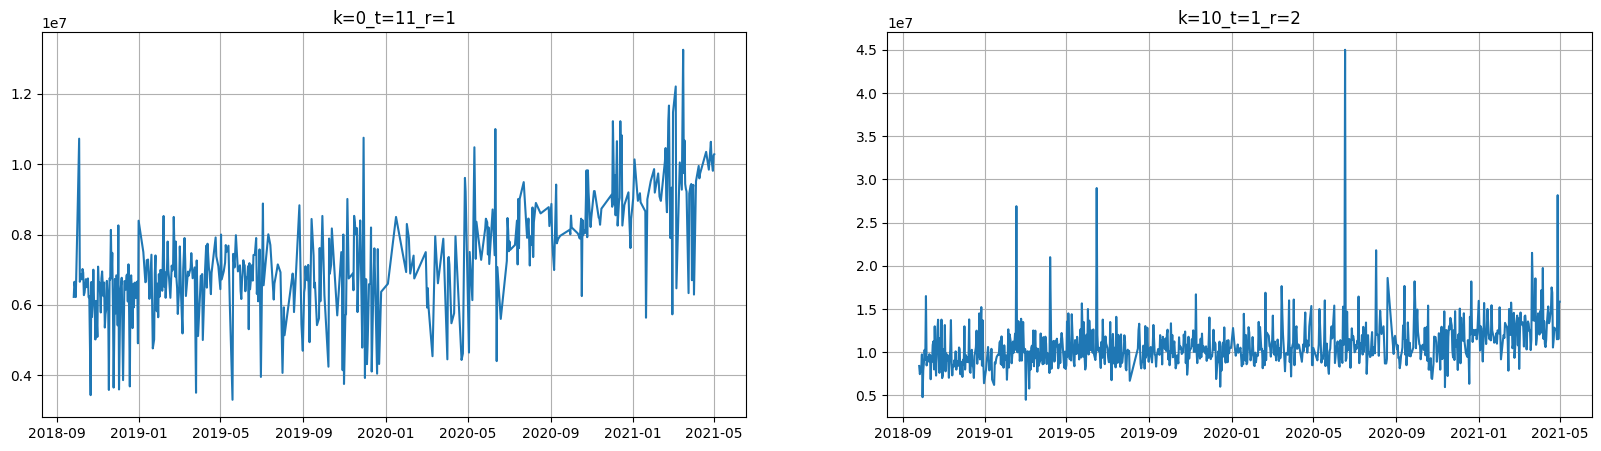

In [35]:
ts.plot(segments=("k=0_t=11_r=1", "k=10_t=1_r=2"))

In [36]:
from etna.transforms import StandardScalerTransform

In [37]:
train_ts, test_ts = ts.train_test_split(
    train_start="2018-09-25",
    train_end="2020-11-01",
    test_start="2020-11-01",
    test_end="2021-05-01",
)

In [38]:
from etna.transforms import LagTransform, LogTransform
HORIZON = 30 * 6
lags = LagTransform(in_column="target", lags=[HORIZON])
#log = LogTransform(in_column="target")
transforms = [lags]
train_ts.fit_transform(transforms)

In [41]:
from etna.models import CatBoostMultiSegmentModel
from etna.models import CatBoostPerSegmentModel
HORIZON = 30 * 6
model =  CatBoostMultiSegmentModel()
model.fit(train_ts)
HORIZON = 30 * 3
future_ts = train_ts.make_future(future_steps=HORIZON, transforms=transforms)
forecast_ts = model.forecast(future_ts)
forecast_ts.inverse_transform(transforms)

In [40]:
from etna.metrics import SMAPE

smape = MAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

ValueError: y_true and y_pred have different timestamps

In [42]:
k  = 1
t = 11
r = 2
segment = f'k={k}_t={t}_r={r}'
test_df = test_ts.to_pandas()
test = test_df[segment]['target']
forecast_df = forecast_ts.to_pandas()
predict = forecast_df[segment]['target']
train_df = train_ts.to_pandas()
train = train_df[segment]['target']

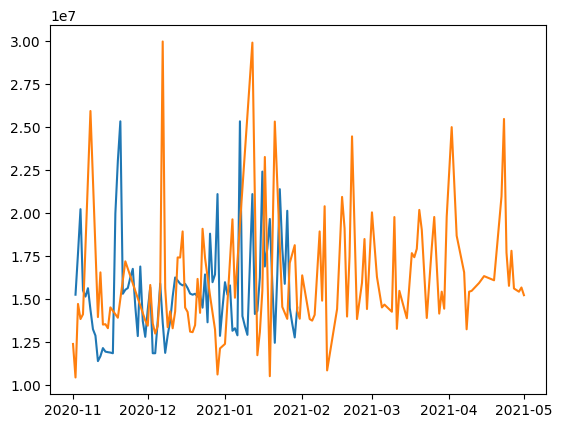

In [44]:
fig, ax = plt.subplots()
ax.plot(predict)
ax.plot(test)
# ax.plot(train)

In [45]:
model.save('../models/model_forcasting_days.sav')